In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft

This is a proof of concept of me and Scott's new dispersion algorithm for CHAMPSS. By storing the kernels dictionary in a yaml file, we can disperse efficiently without either brute force calculations or FDMT. Note that the kernels in this notebook are hardcoded for the CHAMPSS configuration. The dispersion algorithm is as follows:

1. Let $D[g(\phi), DM, N_{chan}, f_l, f_u]$ represent the dispersive function. 
2. For an arbitrary pulse period, calculate $\Delta DM$, the DM at which the pulse is smeared by one period.
3. Calculate $K \equiv D[\delta(\phi), {0, ..., 3\Delta DM}, N_{chan}, f_l, f_u]$ for the CHIME band parameters.
4. Take the FFT of our set $K$ to approximate $\mathcal{F}(K)$.
5. For a pulse profile $G$, take the FFT to approximate $\mathcal{F}(G)$.
6. Disperse the harmonics of $G$:
$$\mathcal{F}(D[G(\phi), {0, ..., 3\Delta DM}, N_{chan}, f_l, f_u]) = K * G = \mathcal{F}(K) \cdot \mathcal{F}(G)$$

In [2]:
Nchan = 16384  # Should probably be 8192 or 16384 to give most accurate kernels
freqs = np.linspace(400.0, 800.0, Nchan)  # in MHz for CHIME band

# A pseudo-impulse response
impulse = np.zeros(1024)
impulse[0] = 1.0

In [3]:
'''
This cell was written by Scott Ransom.
'''
def fft_rotate(arr, bins):
    """
    fft_rotate(arr, bins):
        Return array 'arr' rotated by 'bins' places to the left.  The
            rotation is done in the Fourier domain using the Shift Theorem
            'bins' can be fractional.  The resulting vector will have
            the same length as the original.
    """
    arr = np.asarray(arr)
    freqs = np.arange(arr.size / 2 + 1, dtype=float)
    phasor = np.exp(complex(0.0, 2 * np.pi) * freqs * bins / float(arr.size))
    return np.fft.irfft(phasor * np.fft.rfft(arr), arr.size)


def delay_from_DM(DM, freq):
    """Return the delay caused by DM at freq (MHz)"""
    return DM / (0.000241 * freq**2)

def onewrap_deltaDM(Pspin, Flo=400.0, Fhi=800.0):
    """Return the deltaDM where the dispersion smearing is one pulse period in duration"""
    return Pspin * 0.000241 / (1.0 / Flo**2 - 1.0 / Fhi**2)

In [4]:
def sinc(x):
    return np.sin(x)/x

The pulses are dispersed by calculating the number of bins as a function of the frequency and the ratio of $\frac{P_{spin}}{N_{chan}}$. A new quantity is calculated called $\Delta DM$, which referrs to the DM value at which the pulse is smeared by one full period. This quantity depends on $P_{spin}$, which means we can calculate dispersion kernels that will account for dispersion variation according to pulse period.

In [5]:
Pspin = 5.0
Nbins = 1024
deltaDM = onewrap_deltaDM(Pspin)
DMs = np.linspace(0, 2 * deltaDM, 600)
sums = np.zeros((len(DMs), Nbins))
i = 0

#iterate over DMs and disperse the impulse function 
for DM in DMs:
    sum = np.zeros(Nbins)
    hidelay = delay_from_DM(DM, freqs[-1])
    for freq in freqs:
        #this converts bin delay in time to bin delay in phase
        bins = -(delay_from_DM(DM, freq) - hidelay) / Pspin * Nbins
        #now implement delay
        #plt.plot(fft_rotate(impulse, bins), label = f'freq = {freq}')
        sum += fft_rotate(impulse, bins)
    sums[i] = sum
    i += 1

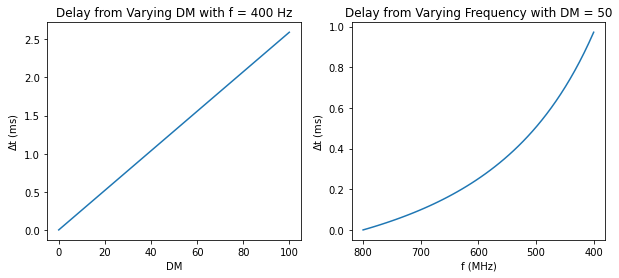

In [115]:
fig, ax = plt.subplots(1, 2, figsize = [10, 4])

temp_dms = np.linspace(0, 100)
ax[0].plot(temp_dms, delay_from_DM(temp_dms, 400.))
ax[0].set_xlabel('DM')
ax[0].set_ylabel(r'$\Delta$t (ms)')
ax[0].set_title('Delay from Varying DM with f = 400 Hz')

temp_freqs = np.linspace(400, 800)
hidelay = delay_from_DM(50, temp_freqs[-1])
ax[1].plot(temp_freqs, delay_from_DM(50, temp_freqs) - hidelay)
ax[1].set_xlabel('f (MHz)')
ax[1].set_ylabel(r'$\Delta$t (ms)')
ax[1].set_title('Delay from Varying Frequency with DM = 50')
ax[1].xaxis.set_inverted(True)

Now we save FFT of these smeared profiles in a dictionary of kernels, and plot what their power spectra look like.

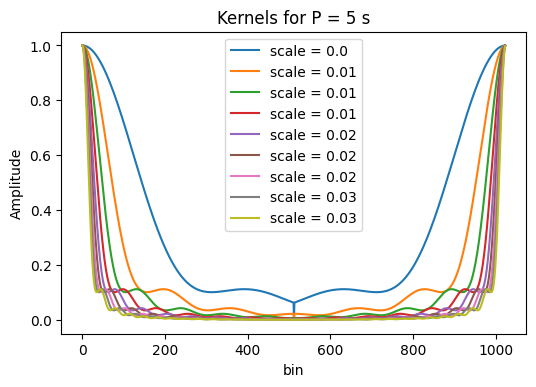

In [13]:
kernels = np.zeros(sums.shape).astype('complex_')
kernel_scaling = DMs/deltaDM
maxamp = max(fft(sums[0]))
for i in range(len(DMs)):
    sum_fft = fft(sums[i])/maxamp
    kernels[i] = sum_fft
    if i > 0 and i < 10:
        plt.plot(np.abs(sum_fft)**2, label = f"scale = {np.round(DMs[i]/deltaDM, 2)}")
np.save('kernels.npy', kernels)
np.save('kernels.meta.npy', kernel_scaling)
plt.title('Kernels for P = 5 s')
plt.xlabel('bin')
plt.ylabel('Amplitude')
plt.legend()

The kernel construction is done. Let's take a look at how the algorithm works. We'll start with a simple Gaussian pulse profile and some power spectra parameters.

In [7]:
def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2)/(sig*np.sqrt(2*np.pi))

phi = np.linspace(0, 1, 1024)
pulse = gaussian(phi, 0.5, 0.02)
nfreqbins = 300000
nDMbins = 6000
df = 9.7e-4
n_harm = 30
full_DMs = np.linspace(-3*deltaDM, 3 * deltaDM, nDMbins)
new_deltaDM = onewrap_deltaDM(1)

In [8]:
def disperse(prof, deltaDM, DM_labels, kernels, kernel_scaling):
    '''
    This function disperses an input pulse profile over a range of -2*deltaDM to 2*deltaDM according
    to the algorithm specified above.

    Inputs:
    -------
            prof (arr)     : 1D array of length 1024 specifying the signal at each phase bin
            deltaDM (float): the DM at which the pulse is smeared by one period
            DM_labels (arr): 1D array specifying the DM labels in the target power spectrum
            kernels (arr)  : 2D array containing the smeared impulse function kernels

    Returns:
    --------
            dispersed_prof_fft (arr): a 2D array of size (len(DM_labels), len(prof)) containing the
                                      dispersed profile values
    '''
    
    #take the fft of the pulse
    prof_fft = fft(prof)

    #i is our index referring to the DM_labels in the target power spectrum
    #find the starting index, where the DM scale is -2
    i = np.argmin(np.abs(-2*deltaDM - DM_labels))
    i0 = np.argmin(np.abs(DM_labels))
    #find the stopping index, where the DM scale is +2
    i_max = np.argmin(np.abs(2*deltaDM - DM_labels))

    dispersed_prof_fft = np.zeros((len(DM_labels), len(prof)), dtype = 'complex_')

    while i <= i_max:
        #j is the index referring to the closest value in DMs
        '''this can def be optimized by figuring out how many DM bins fit into
        each kernel bin between diff dms and then increasing j by that amount each iteration
        but i will save that for future optimization'''
        key = np.argmin(np.abs(np.abs(DM_labels[i]/deltaDM) - kernel_scaling))
        dispersed_prof_fft[i] = prof_fft * kernels[key]
        i += 1

    return dispersed_prof_fft

Our harmonics are calculated using the sinc function to disperse the power across channels neighboring the true channel, which almost always has a fractional value.

In [9]:
def sinc(x):
    return np.sin(x)/x


def harmonics(prof_fft, f_true, df, n_harm):
    
    """This function calculates the array of frequency-domain harmonics for a given pulse profile.

    Inputs:
    _______
            prof (ndarray): pulse phase profile
            f_true (float): true rotational frequency in Hz
            df (float)    : frequency bin width in target spectrum

    Returns:
    ________
            harmonics (ndarray) : Fourier-transformed harmonics of the profile convolved with
                                    [cycles] number of Delta functions
    """
    #currently we are calculating the first 10 harmonics in the 2 bins on either side of the true value (2 + 2 = 4)
    harmonics = np.zeros((4*n_harm))
    bins = np.zeros((4*n_harm)).astype(int)
    
    #now evaluate sinc-modified power at each of the first 10 harmonics
    for i in range(1, n_harm + 1):
        f_harm = i*f_true
        bin_true = f_harm/df
        bin_below = np.floor(bin_true)
        bin_above = np.ceil(bin_true)

        #use 2 bins on either side
        current_bins = np.array([bin_below - 1, bin_below, bin_above, bin_above + 1])
        bins[(i - 1)*4:(i - 1)*4+4] = current_bins
        amplitude = prof_fft[i]*sinc(np.pi*(bin_true - current_bins))
        harmonics[(i - 1)*4:(i - 1)*4+4] = np.abs(amplitude)**2

    return bins, harmonics

Text(0.5, 1.0, 'Dispersed Harmonics of a Gaussian Pulse With Kernel Algorithm')

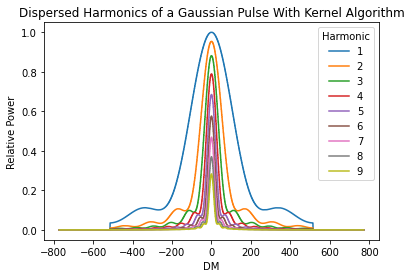

In [10]:
dispersed_prof_fft = disperse(pulse, deltaDM, full_DMs, kernels, kernel_scaling)
maxpower = max(np.abs(dispersed_prof_fft[:, 1])**2)
for i in range(1, 10):
    plt.plot(full_DMs, np.abs(dispersed_prof_fft[:, i])**2/maxpower, label = i)
plt.xlabel('DM')
plt.ylabel('Relative Power')
plt.legend(title = 'Harmonic')
plt.title('Dispersed Harmonics of a Gaussian Pulse With Kernel Algorithm')

Now we'll use `harmonics()` to smear the dispersed harmonics over the appropriate bins in the target power spectrum.

In [11]:
smeared_harm = np.zeros((len(full_DMs), nfreqbins))
for i in range(len(smeared_harm)):
    bins, harm = harmonics(dispersed_prof_fft[i], 1/Pspin, df, n_harm)
    smeared_harm[i, bins] = harm

Zoom in on the first ten harmonics...

Text(0.02, 0.5, 'DM$_{trial}$')

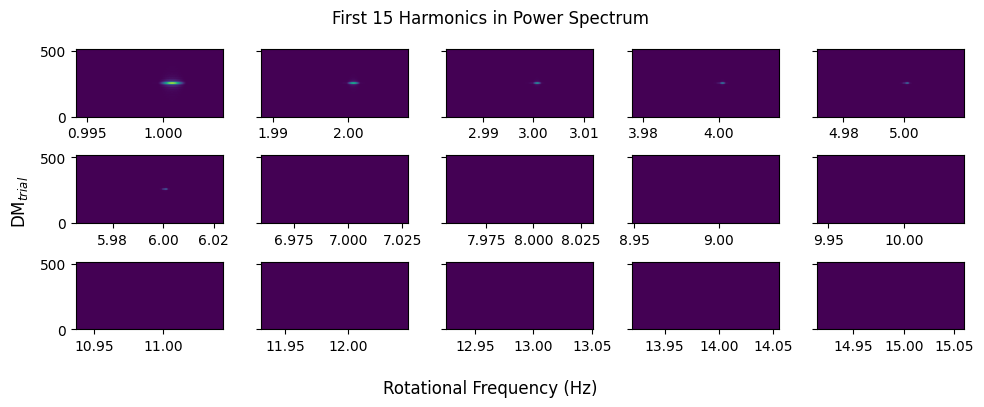

In [12]:
plt.rcParams["figure.dpi"] = 100
fig, ax = plt.subplots(3, 5, figsize=(10, 4), sharey = True, tight_layout = True)
ax = ax.flatten()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
for i in range(0, 15):                                                             
    ax[i].imshow(smeared_harm[:, (i+1)*1025:(i+1)*1035], 
                 extent = [df*(i+1)*1025, df*(i+1)*1035, 0, max(DMs)],
                  aspect = 'auto')
fig.suptitle('First 15 Harmonics in Power Spectrum')
fig.supxlabel('Rotational Frequency (Hz)')
fig.supylabel(r'DM$_{trial}$')

Now let's take a look at a real pulsar from the Thousand Pulsar Array project on MeerKAT (Posselt, et al (2023). The Thousand Pulsar Array program on MeerKAT – IX. The time-averaged properties of the observed pulsar population. Monthly Notices of the Royal Astronomical Society, 520(3), 4582–4600. https://doi.org/10.1093/mnras/stac3383). 

Here's the pulse profile:

In [67]:
centered_pulses = np.loadtxt('centered_pulses.txt')
TPA_pulse = centered_pulses[4]
plt.plot(phi, TPA_pulse)
plt.xlabel(r'$\phi$')
plt.ylabel('Stokes Intensity')
plt.title('A TPA Pulsar With Noise and Spiky Features')

FileNotFoundError: centered_pulses.txt not found.

In [ ]:
P_spin_TPA = 3.21 #this is random
delta_DM_TPA = onewrap_deltaDM(P_spin_TPA)
dispersed_TPA_fft = disperse(pulse, delta_DM_TPA, full_DMs, kernels, kernel_scaling)
smeared_TPA_harm = np.zeros((len(full_DMs), nfreqbins))
for i in range(len(smeared_TPA_harm)):
    bins, harm = harmonics(dispersed_TPA_fft[i], 1/P_spin_TPA, df, n_harm = 10)
    smeared_TPA_harm[i, bins] = harm

Text(0.02, 0.5, 'DM$_{trial}$')

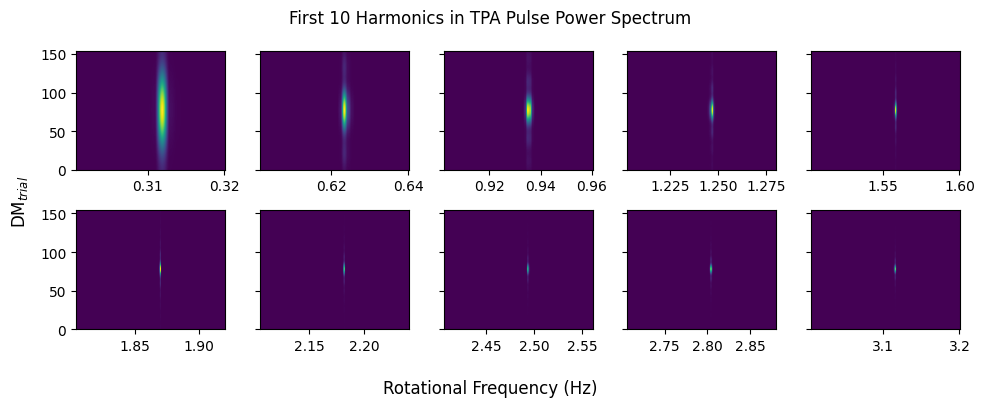

In [ ]:
plt.rcParams["figure.dpi"] = 100
fig, ax = plt.subplots(2, 5, figsize=(10, 4), sharey = True, tight_layout = True)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(smeared_TPA_harm[:, (i+1)*310:(i+1)*330], 
                 extent = [df*(i+1)*310, df*(i+1)*330, 0, max(DMs)],
                  aspect = 'auto')
fig.suptitle('First 10 Harmonics in TPA Pulse Power Spectrum')
fig.supxlabel('Rotational Frequency (Hz)')
fig.supylabel(r'DM$_{trial}$')

Everything is smeared out!